In [2]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

from sklearn import datasets
from dal_toolbox.models.utils.mcdropout import MCDropoutModule, ConsistentMCDropout
from dal_toolbox.models.mc_dropout import MCDropoutTrainer, MCDropoutModel
from dal_toolbox.models.utils.callbacks import MetricHistory

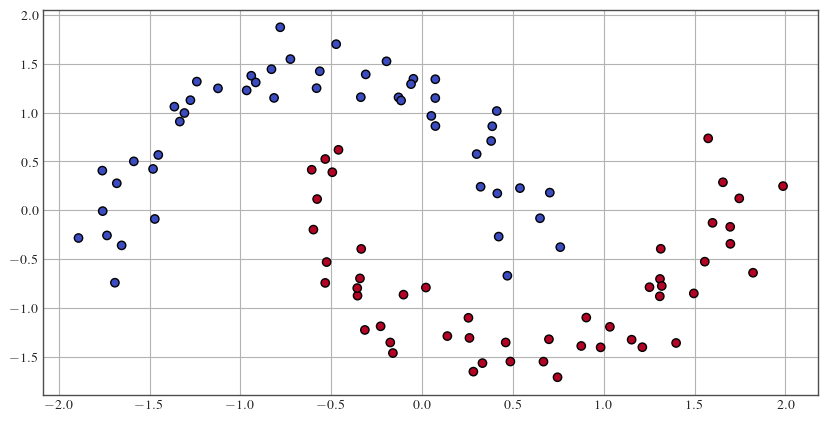

In [3]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [4]:
class Net(MCDropoutModule):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__(n_passes=50)

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = ConsistentMCDropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = ConsistentMCDropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

In [5]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model.mc_forward(zz)
    probas = logits.softmax(-1)
    probas = probas.mean(1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [1]  [0/1]  eta: 0:00:00  lr: 0.1000  loss: 0.7192 (0.7192)  acc1: 0.5300 (0.5300)  time: 0.1609  data: 0.0011  max mem: 17
Epoch [1] Total time: 0:00:00
Epoch [2]  [0/1]  eta: 0:00:00  lr: 0.1000  loss: 0.6266 (0.6266)  acc1: 0.6900 (0.6900)  time: 0.0020  data: 0.0006  max mem: 18
Epoch [2] Total time: 0:00:00
Epoch [3]  [0/1]  eta: 0:00:00  lr: 0.1000  loss: 0.5553 (0.5553)  acc1: 0.7300 (0.7300)  time: 0.0019  data: 0.0006  max mem: 18
Epoch [3] Total time: 0:00:00
Epoch [4]  [0/1]  eta: 0:00:00  lr: 0.1000  loss: 0.4905 (0.4905)  acc1: 0.7700 (0.7700)  time: 0.0021  data: 0.0006  max mem: 18
Epoch [4] Total time: 0:00:00
Epoch [5]  [0/1]  eta: 0:00:00  lr: 0.1000  loss: 0.4753 (0.4753)  acc1: 0.7900 (0.7900)  time: 0.0025  data: 0.0008  max mem: 18
Epoch [5] Total time: 0:00:00
Epoch [6]  [0/1]  eta: 0:00:00  lr: 0.1000  loss: 0.3539 (0.3539)  acc1: 0.8900 (0.8900)  time: 0.0031  data: 0.0016  max mem: 18
Epoch [6] Total time: 0:00:00
Epoch [7]  [0/1]  eta: 0:00:00  lr: 0.10

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


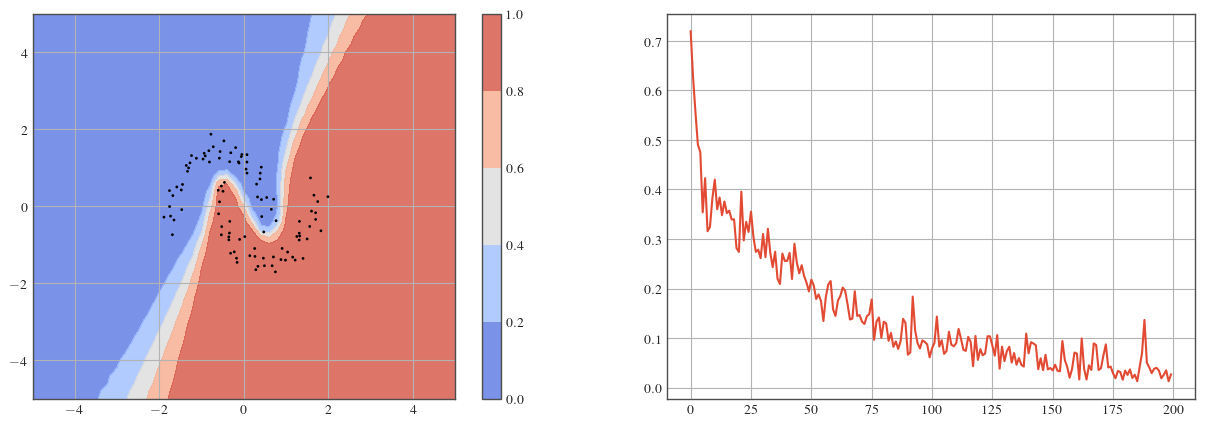

In [6]:
dropout_rate = 0.6
num_epochs = 200
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model=Net(dropout_rate=dropout_rate, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=.9)
trainer = MCDropoutTrainer(
    model,
    nn.CrossEntropyLoss(),
    optimizer=optimizer,
    num_epochs=num_epochs,
)
history = trainer.fit(train_loader)


model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history['train_history']])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/denis/Documents/projects/uncertainty_evaluation/dal_toolbox/models/mc_dropout/base.py:53: UserWarning: Using default optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
).
  warnings.warn(f'Using default optimizer: {optimizer}.')

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Net              | 17.2 K
1 | metrics | ModuleDict       | 0     
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 209.05it/s, v_num=91, train_loss=0.0484] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 124.82it/s, v_num=91, train_loss=0.0484]


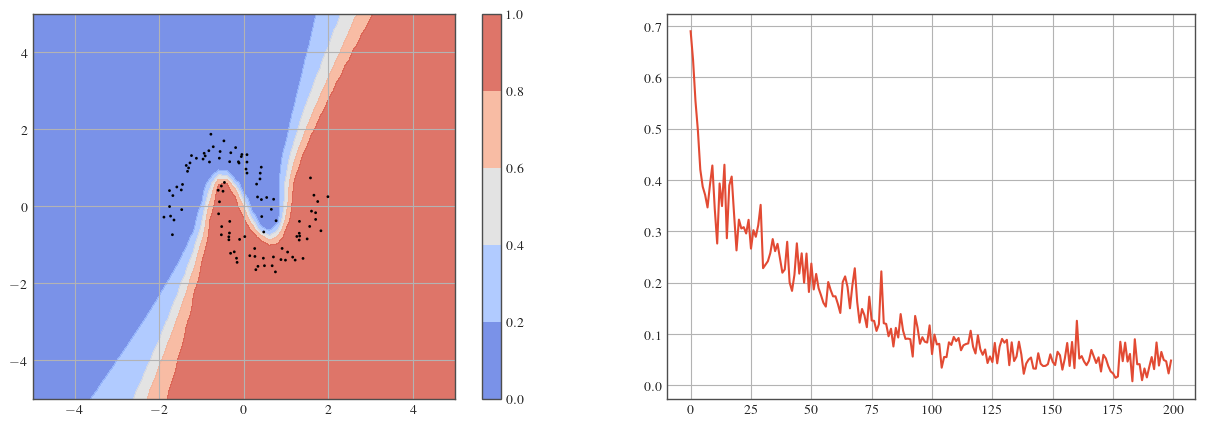

In [7]:
dropout_rate = 0.6
num_epochs = 200
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = MCDropoutModel(
    model=Net(dropout_rate=dropout_rate, num_classes=2),
)
history = MetricHistory()
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history])
trainer.fit(model, train_loader)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()